In [81]:
from pathlib import Path
import matplotlib.pyplot as plt
import json
import pandas as pd
from environment import Environment

In [88]:
# Paths of models to evalute
# environment = Environment(Path(f"./environments/dilemma"), groups_file='./groups.txt')
# constraints = ForwardConstraints(environment.grid_x_size, environment.grid_y_size, environment.existing_lines_full, environment.grid_to_vector)
models = ['dilemma_5x5_20220503_13_58_29.563962', 'dilemma_5x5_20220503_17_47_23.454216', 'dilemma_5x5_20220419_13_22_47.509481', 
            'dilemma_5x5_20220503_13_57_24.615759',
            'dilemma_5x5_20220418_17_43_08.080415', 'dilemma_5x5_20220503_15_18_36.055557', 'dilemma_5x5_20220503_16_36_50.970871']

lines, group_ginis, group_pct_ginis, group_ods, group_ods_pct, group_pct_diff = [], [], [], [], [], []
for model_path in models:
    with open(Path('result', model_path, 'result_metrics.json')) as json_file:
        data = json.load(json_file)
        lines.append(data['avg_generated_line'])
        group_ods.append(data['mean_sat_group_od'])
        group_ods_pct.append(data['mean_sat_group_od_pct'])
        group_ginis.append(0.5-data['group_gini'])
        group_pct_ginis.append(0.5-data['group_pct_gini'])
        group_pct_diff.append(1-abs(data['mean_sat_od_by_group_pct'][0] - data['mean_sat_od_by_group_pct'][1]))



In [89]:
metrics = pd.DataFrame(zip(models, lines, group_ods, group_ods_pct, group_ginis, group_pct_ginis, group_pct_diff), 
                columns=['model', 'line', 'group_od', 'group_ods_pct', 'group_gini', 'group_pct_gini', 'group_pct_diff'])

metrics

,model,line,group_od,group_ods_pct,group_gini,group_pct_gini,group_pct_diff
0,dilemma_5x5_20220503_13_58_29.563962,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0...",9.0,0.825688,0.111111,0.285223,0.420760
1,dilemma_5x5_20220503_17_47_23.454216,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0...",9.0,0.825688,0.111111,0.285223,0.420760
2,dilemma_5x5_20220419_13_22_47.509481,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0...",9.0,0.825688,0.111111,0.285223,0.420760
3,dilemma_5x5_20220503_13_57_24.615759,"[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [4, 1...",5.0,0.458716,0.160000,0.378132,0.801668
4,dilemma_5x5_20220418_17_43_08.080415,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0...",9.0,0.825688,0.111111,0.285223,0.420760
5,dilemma_5x5_20220503_15_18_36.055557,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 4...",5.6,0.513761,0.285714,0.439189,0.866543
6,dilemma_5x5_20220503_16_36_50.970871,"[[0, 2], [0, 3], [0, 4], [1, 2], [2, 2], [3, 2...",3.6,0.330275,0.388889,0.329873,0.726599


(0.0, 1.0)

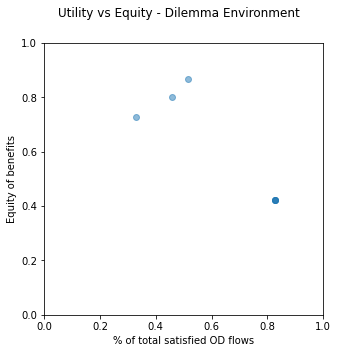

In [78]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(group_ods_pct, group_pct_diff, alpha=0.5)
ax.set_xlabel('% of total satisfied OD flows')
ax.set_ylabel('Equity of benefits')
fig.suptitle('Utility vs Equity - Dilemma Environment')
ax.set_ylim((0,1))
ax.set_xlim((0,1))

# for i, txt in enumerate(models):
#     ax.annotate(txt, (group_ods_pct[i], group_pct_ginis[i]))

In [80]:
# import plotly.express as px
# fig = px.scatter(metrics, x='group_ods_pct', y='group_pct_diff', 
#                 labels={'group_ods_pct': '% of total satisfied OD flows', 'group_pct_diff': 'Equity of benefits (1-difference)'}, title='Utility vs Equity - Dilemma Environment',
#                 hover_name="model")
# fig.update_xaxes(range=[0, 1])
# fig.update_yaxes(range=[0, 1])
# fig.update_layout(
#     autosize=False,
# )
# fig.show()

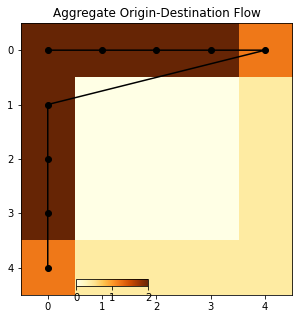

In [106]:
# TODO: transfer this method to the environment class.
import torch
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dilemma = Environment(Path(f"./environments/dilemma_5x5"))

def calculate_agg_od(environment):
    """Calculate aggregate origin-destination flow matrix for each grid square of the given environment.

    Args:
        environment (Environment): environment for which to calcualte aggregate OD per grid square.

    Returns:
        torch.Tensor: aggregate od by grid
    """
    # 
    # A measure of importance of each square.
    agg_od_g = torch.zeros((environment.grid_x_size, environment.grid_y_size)).to(device)
    agg_od_v = environment.od_mx.sum(axis=1)
    # Get the grid indices.
    for i in range(agg_od_v.shape[0]):
        g = environment.vector_to_grid(torch.Tensor([i])).type(torch.int32)
        agg_od_g[g[0], g[1]] = agg_od_v[i]

    return agg_od_g

dilemma_od = calculate_agg_od(dilemma).cpu()
fig, ax = plt.subplots(figsize=(5, 5))

im0 = ax.imshow(dilemma_od, cm.get_cmap('YlOrBr'))
cax = fig.add_axes([0.29, 0.15, 0.2, 0.02])
fig.colorbar(im0, cax=cax, orientation='horizontal')
ax.set_title('Aggregate Origin-Destination Flow')


for i, l in enumerate([metrics.iloc[0]['line']]):
    l_g = list(zip(*l))
    ax.plot(l_g[1], l_g[0], '-ok')
    # axs[1].plot(l_v[1], l_v[0], '-or', label=label)
